In [ ]:
import requests
import json
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h1>== request data ==</h1>

In [ ]:
response = requests.get('https://public.opendatasoft.com/api/records/1.0/search/?dataset=titanic-passengers&q=&rows=891&facet=survived&facet=pclass&facet=sex&facet=age&facet=embarked')
rawData = response.json()
selectData = []
data = rawData['records']
for i in range(len(data)):
  selectData.append(data[i]['fields'])
df = pd.DataFrame(selectData)

df.head()

,fare,name,embarked,age,parch,pclass,sex,survived,ticket,passengerid,sibsp,cabin
0,7.7750,"Birkeland, Mr. Hans Martin Monsen",S,21.0,0,3,male,No,312992,409,0,NaN
1,7.9250,"Heikkinen, Miss. Laina",S,26.0,0,3,female,Yes,STON/O2. 3101282,3,0,NaN
2,7.9250,"Sundman, Mr. Johan Julian",S,44.0,0,3,male,Yes,STON/O 2. 3101269,415,0,NaN
3,18.7500,"Richards, Mrs. Sidney (Emily Hocking)",S,24.0,3,2,female,Yes,29106,438,2,NaN
4,89.1042,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",C,NaN,0,1,female,Yes,17453,850,1,C92


<h1>== pre-processing ==</h1>

<h4>- explore data -</h4>

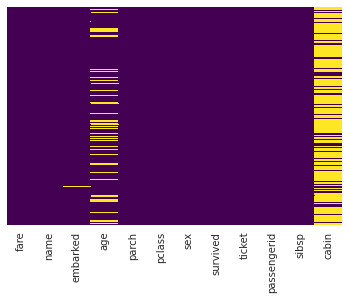

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<h4>- fill missing data -</h4>

In [ ]:
df.groupby('pclass')['age'].median()

pclass
1    37.0
2    29.0
3    24.0
Name: age, dtype: float64

In [ ]:
def impute_age(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return 37
        elif pclass == 2:
            return 29
        else:
            return 24
    else:
        return age

df['age'] = df[['age','pclass']].apply(impute_age,axis=1)

In [ ]:
df['embarked'].mode()

0    S
dtype: object

In [ ]:
def impute_embarked(embarked):   
    if pd.isnull(embarked):
        return 'S'
    else:
        return embarked

df['embarked'] = df['embarked'].apply(impute_embarked)

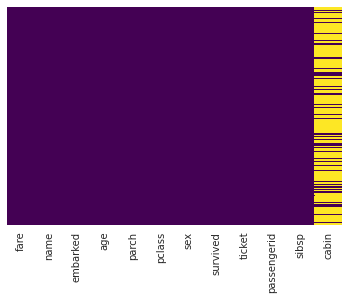

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

<h4>- drop unsignificant column -</h4>

In [ ]:
df.drop(['cabin','name','ticket','passengerid'],axis=1,inplace=True)

df.head()

,fare,embarked,age,parch,pclass,sex,survived,sibsp
0,7.7750,S,21.0,0,3,male,No,0
1,7.9250,S,26.0,0,3,female,Yes,0
2,7.9250,S,44.0,0,3,male,Yes,0
3,18.7500,S,24.0,3,2,female,Yes,2
4,89.1042,C,37.0,0,1,female,Yes,1


<h4>- convert categorical features -</h4>

In [ ]:
embarked = pd.get_dummies(df['embarked'],drop_first=True)
sex = pd.get_dummies(df['sex'],drop_first=True)
survived = pd.get_dummies(df['survived'],drop_first=True)

In [ ]:
embarked.head()

,Q,S
0,0,1
1,0,1
2,0,1
3,0,1
4,0,0


In [ ]:
sex.head()

,male
0,1
1,0
2,1
3,0
4,0


In [ ]:
survived.head()

,Yes
0,0
1,1
2,1
3,1
4,1


In [ ]:
df.drop(['embarked','sex','survived'],axis=1,inplace=True)
df = pd.concat([df,embarked,sex,survived],axis=1)

df.head()

,fare,age,parch,pclass,sibsp,Q,S,male,Yes
0,7.7750,21.0,0,3,0,0,1,1,0
1,7.9250,26.0,0,3,0,0,1,0,1
2,7.9250,44.0,0,3,0,0,1,1,1
3,18.7500,24.0,3,2,2,0,1,0,1
4,89.1042,37.0,0,1,1,0,0,0,1


<h1>== building logistic regression model ==</h1>

<h4>- train&test splitting -</h4>

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop('Yes',axis=1)
y = df['Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=1010)

<h4>- training & prediction -</h4>

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
output = model.predict(X_test)

<h1>== evaluation == </h1>


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,output))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       165
           1       0.79      0.69      0.74       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.81      0.81      0.81       268

